In [4]:
pip install mplfinance

Note: you may need to restart the kernel to use updated packages.


/var/folders/3n/c2cyvjmd52585bcd83mjw9dw0000gp/T/ipykernel_15910/1048851214.py:78: FutureWarning: YF.download() has changed argument auto_adjust default to True
  nvda_data = yf.download('NVDA', start='2025-01-01', end='2025-08-31')
[*********************100%***********************]  1 of 1 completed


---------------------------------------------
Ensemble Indicator Analysis for NVDA on 2025-08-04
---------------------------------------------
1. 22-Day Moving Average Signal: Bullish
2. 10-Day RSI Signal:              Bullish (Not Overbought)
3. Parabolic SAR Signal:         Bullish
4. ADX Trend Signal:             Bullish
---------------------------------------------
Bullish Indicator Count: 4 out of 4
FINAL ENSEMBLE SIGNAL: BULLISH
---------------------------------------------


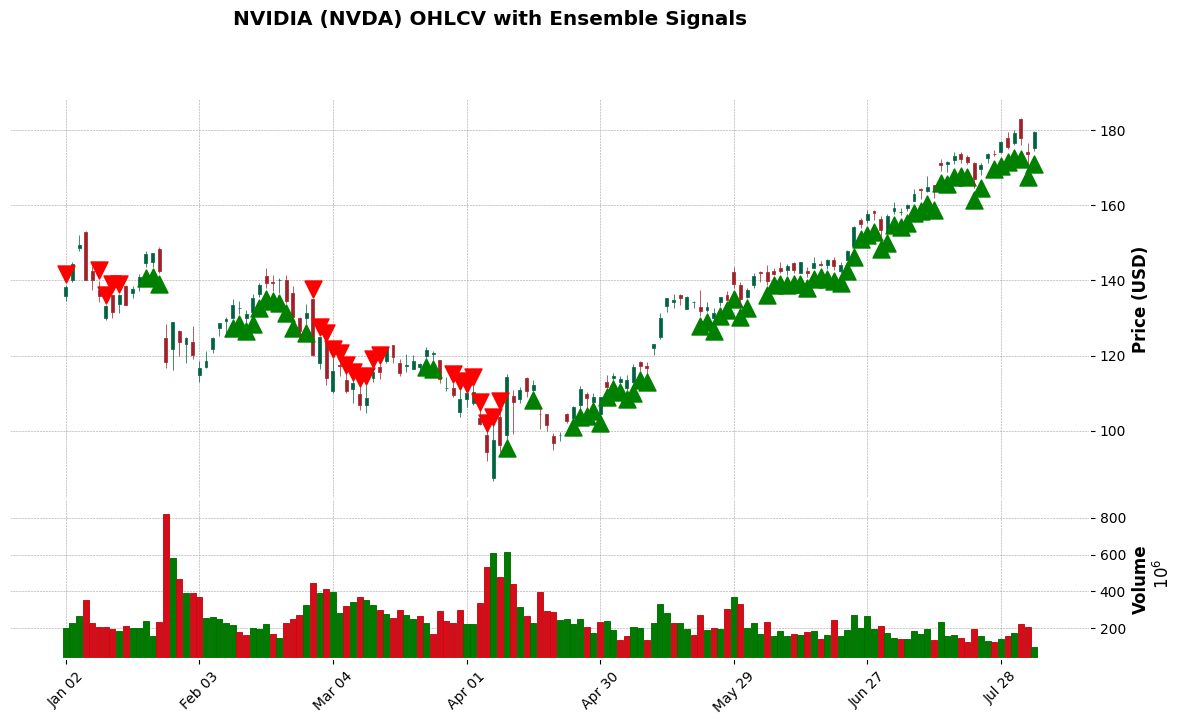

In [6]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import mplfinance as mpf

# --- Indicator Calculation Functions ---

def calculate_adx(high, low, close, window=14):
    """Calculates the Average Directional Index (ADX), +DI, and -DI."""
    tr1 = high - low
    tr2 = abs(high - close.shift(1))
    tr3 = abs(low - close.shift(1))
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    atr = tr.ewm(alpha=1/window, adjust=False).mean()

    plus_dm = high.diff()
    minus_dm = low.diff().mul(-1)
    plus_dm[(plus_dm < 0) | (plus_dm <= minus_dm)] = 0
    minus_dm[(minus_dm < 0) | (minus_dm <= plus_dm)] = 0
    
    plus_di = 100 * plus_dm.ewm(alpha=1/window, adjust=False).mean() / atr
    minus_di = 100 * minus_dm.ewm(alpha=1/window, adjust=False).mean() / atr

    dx = 100 * (abs(plus_di - minus_di) / (plus_di + minus_di))
    adx = dx.ewm(alpha=1/window, adjust=False).mean()
    
    return pd.DataFrame({'ADX': adx, '+DI': plus_di, '-DI': minus_di})

def calculate_rsi(data, window=10):
    """Calculates the 10-day RSI."""
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).fillna(0)
    loss = (-delta.where(delta < 0, 0)).fillna(0)
    avg_gain = gain.ewm(com=window - 1, min_periods=window).mean()
    avg_loss = loss.ewm(com=window - 1, min_periods=window).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calculate_parabolic_sar(high, low, initial_af=0.02, max_af=0.2):
    """Calculates the Parabolic SAR."""
    length = len(high)
    psar = [np.nan] * length
    bullish = True
    af = initial_af
    ep = high.iloc[0]
    psar[0] = low.iloc[0]

    for i in range(1, length):
        if bullish:
            psar[i] = psar[i-1] + af * (ep - psar[i-1])
        else:
            psar[i] = psar[i-1] - af * (abs(ep - psar[i-1]))

        reverse = False
        if bullish and low.iloc[i] < psar[i]:
            bullish, reverse = False, True
            psar[i], ep, af = ep, low.iloc[i], initial_af
        elif not bullish and high.iloc[i] > psar[i]:
            bullish, reverse = True, True
            psar[i], ep, af = ep, high.iloc[i], initial_af

        if not reverse:
            if bullish and high.iloc[i] > ep:
                ep, af = high.iloc[i], min(af + initial_af, max_af)
            elif not bullish and low.iloc[i] < ep:
                ep, af = low.iloc[i], min(af + initial_af, max_af)
        
        if bullish:
            psar[i] = min(psar[i], low.iloc[i-1], low.iloc[i] if i > 0 else low.iloc[i])
        else:
            psar[i] = max(psar[i], high.iloc[i-1], high.iloc[i] if i > 0 else high.iloc[i])
            
    return pd.Series(psar, index=high.index)

# --- 1. Data Fetching ---
nvda_data = yf.download('NVDA', start='2025-01-01', end='2025-08-31')

    
if isinstance(nvda_data.columns, pd.MultiIndex):
        # Option A – drop the outer level (works when only one ticker):
    nvda_data = nvda_data.droplevel(1, axis=1)


# --- 2. Indicator Calculation ---
nvda_data['MA22'] = nvda_data['Close'].rolling(window=22).mean()
nvda_data['RSI10'] = calculate_rsi(nvda_data['Close'], window=10)
nvda_data['PSAR'] = calculate_parabolic_sar(nvda_data['High'], nvda_data['Low'])
adx_data = calculate_adx(nvda_data['High'], nvda_data['Low'], nvda_data['Close'])
nvda_data = nvda_data.join(adx_data)

# --- 3. Ensemble "Voting Poll" Signal Generation ---
bullish_score = pd.Series(0, index=nvda_data.index)
bullish_score[nvda_data['Close'] > nvda_data['MA22']] += 1
bullish_score[nvda_data['RSI10'] < 70] += 1 
bullish_score[nvda_data['Close'] > nvda_data['PSAR']] += 1
bullish_score[(nvda_data['+DI'] > nvda_data['-DI']) & (nvda_data['ADX'] > 25)] += 1
nvda_data['Bullish_Score'] = bullish_score

nvda_data['Signal'] = 0
nvda_data.loc[bullish_score >= 3, 'Signal'] = 1
nvda_data.loc[bullish_score <= 1, 'Signal'] = -1

# --- 4. Final Day Analysis Text Output ---
last_day = nvda_data.iloc[-1]
print("---" * 15)
print(f"Ensemble Indicator Analysis for NVDA on {last_day.name.date()}")
print("---" * 15)

# Individual Indicator Signals
ma_signal = "Bullish" if last_day['Close'] > last_day['MA22'] else "Bearish"
rsi_signal = "Bullish (Not Overbought)" if last_day['RSI10'] < 70 else "Bearish (Overbought)"
psar_signal = "Bullish" if last_day['Close'] > last_day['PSAR'] else "Bearish"
adx_signal = "Bullish" if (last_day['+DI'] > last_day['-DI']) and (last_day['ADX'] > 25) else "Bearish/Weak"

print(f"1. 22-Day Moving Average Signal: {ma_signal}")
print(f"2. 10-Day RSI Signal:              {rsi_signal}")
print(f"3. Parabolic SAR Signal:         {psar_signal}")
print(f"4. ADX Trend Signal:             {adx_signal}")
print("---" * 15)

# Final Ensemble Signal
final_signal_text = "Neutral"
if last_day['Signal'] == 1:
    final_signal_text = "BULLISH"
elif last_day['Signal'] == -1:
    final_signal_text = "BEARISH"

print(f"Bullish Indicator Count: {int(last_day['Bullish_Score'])} out of 4")
print(f"FINAL ENSEMBLE SIGNAL: {final_signal_text}")
print("---" * 15)


# --- 5. Simplified Visualization ---
# Prepare scatter plot data for buy/sell signals
buy_markers = np.where(nvda_data['Signal'] == 1, nvda_data['Low'] * 0.98, np.nan)
sell_markers = np.where(nvda_data['Signal'] == -1, nvda_data['High'] * 1.02, np.nan)

# Create additional plots for the markers
# The correct keyword for marker size in mplfinance is 'markersize'
add_plots = [
    mpf.make_addplot(buy_markers, type='scatter', marker='^', color='green', markersize=150),
    mpf.make_addplot(sell_markers, type='scatter', marker='v', color='red', markersize=150)
]

# Create the candlestick chart with volume and signals
mpf.plot(nvda_data, 
         type='candle', 
         style='charles', 
         title='NVIDIA (NVDA) OHLCV with Ensemble Signals',
         ylabel='Price (USD)',
         volume=True,
         ylabel_lower='Volume',
         addplot=add_plots,
         figsize=(15, 8))
